# **Clustering Analysis Result Summary**
**Recency :** 

- Customers in `Cluster 1` has a higher loyalty.
- `Cluster 1` has a higher frequency on purchasing. 

**Frequency :**

- Purchasing Frequency : `Cluster 1` > `Cluster 2` > `Cluster 3` .

**Monetary :**

- Customers in `Cluster 1` has a higher distribution on sales revenue to the store.

**Location :**

- No Significant difference on clusters.

**Other Groups :**

- `Cluster 0` and `Cluster 6` mostly contain outliers.
- I consider `Cluster 0` and `Cluster 6` are noise customers in the dataset.

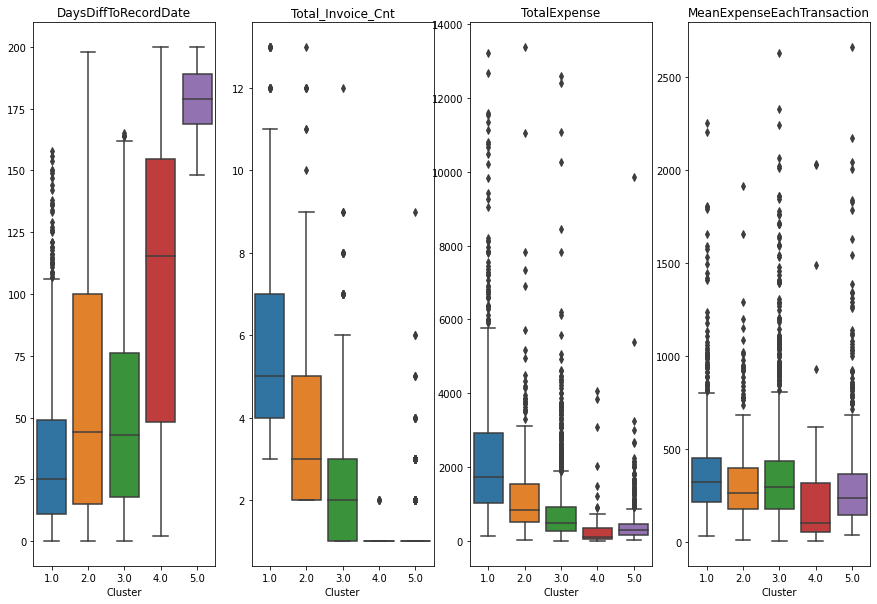

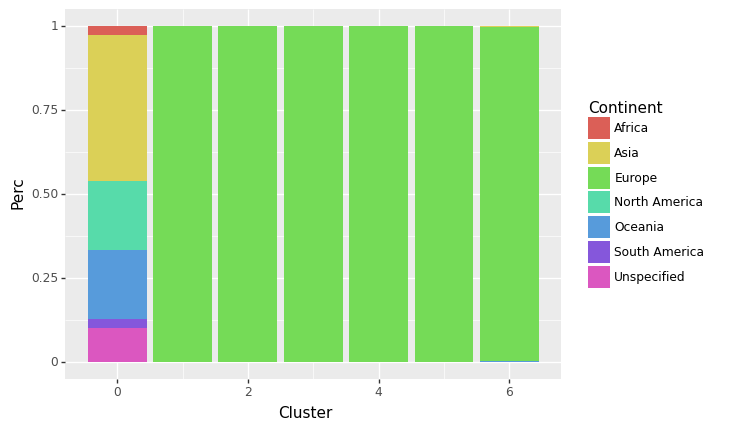

# ***Programming Start :***

# **Data Information**

Data Link:

https://archive.ics.uci.edu/ml/datasets/Online+Retail

External Data source Link :

https://github.com/dbouquin/IS_608/blob/master/NanosatDB_munging/Countries-Continents.csv

Data Desciption:

>1.   InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
>2.   StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
>3.   Description: Product (item) name. Nominal.
>4.   Quantity: The quantities of each product (item) per transaction. Numeric.
>5.   InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
>6.   UnitPrice: Unit price. Numeric, Product price per unit in sterling.
>7.   CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
>8.   Country: Country name. Nominal, the name of the country where each customer resides. 



# **Import Data and Modules**

In [1]:
!pip install datatable
from pickle import load, dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt
import datetime 
from dateutil import relativedelta
import re
from functools import reduce

     |████████████████████████████████| 96.9 MB 28 kB/s 


In [10]:
data = dt.fread("/content/Online Retail.xlsx").to_pandas()
print(data.shape)

(541909, 8)


Add more keys and values to the contry to continent dictionary to complete the mapping process.

In [11]:
country_continent = pd.read_csv("/content/Countries-Continents.csv")
country_continent
#create mapping dictionary
country_map_continent = dict(zip(country_continent["Country"], country_continent["Continent"]))
# Since there is a kind of value in country call "Unspecified", I create a key:value for it.
country_map_continent["Unspecified"] = "Unspecified"
print(set(list(country_map_continent.values())))
country_map_continent["EIRE"] = "Europe"
country_map_continent["Channel Islands"] = "Europe"
country_map_continent["USA"] = 'North America'
country_map_continent["Hong Kong"] = "Asia"
country_map_continent["European Community"] = "Europe"
country_map_continent["RSA"] = "Africa"
country_map_continent["Czech Republic"] = "Europe"

{'South America', 'Africa', 'Europe', 'Asia', 'Unspecified', 'Oceania', 'North America'}


# **A Glimpse on Data.**

- Including Data Cleansing.

In [12]:
print("Data types:\n\n", data.dtypes, end = "\n\n")
print("Missing count:\n\n", data.isna().sum())

Data types:

 InvoiceNo       object
StockCode       object
Description     object
Quantity         int32
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Missing count:

 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Check the time period whether is within a year?

In [13]:
print("Latest Date :", data["InvoiceDate"].max())
print("Oldest Date :", data["InvoiceDate"].min())

Latest Date : 2011-12-09 12:50:00
Oldest Date : 2010-12-01 08:26:00


Generate Time relevant variables.
Create time columns with smaller data granularity information.

In [14]:
sales_df = data.copy()
sales_df["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"], format = '%Y-%m-%d %H:%M:%S')
sales_df["Year"] = sales_df["InvoiceDate"].dt.year
sales_df["Quarter"] = sales_df["InvoiceDate"].dt.quarter
sales_df["Month"] = sales_df["InvoiceDate"].dt.month
sales_df["Day"] = sales_df["InvoiceDate"].dt.day
sales_df["Hour"] = sales_df["InvoiceDate"].dt.hour
sales_df["Minute"] = sales_df["InvoiceDate"].dt.minute
sales_df["YearQuarter"] = sales_df["Year"].astype(str) + "-" + sales_df["InvoiceDate"].dt.quarter.astype(str)
sales_df["YearMonth"] = sales_df["InvoiceDate"].dt.strftime("%Y-%m")
sales_df["YearMonthDay"] = sales_df["InvoiceDate"].dt.strftime("%Y-%m-%d")

Add a column to label whether the description is missing or not.

In [16]:
sales_df["Missing Description"] = np.where(data["Description"].isnull(), "Description Missing", "Description Not Missing")

Add a column show the distinct stock code that are represented by the first 5 digitin "StockCode".

In [17]:
sales_df["Unique Stock Code"] = sales_df["StockCode"].str.slice(start = 0, stop = 5)

Create a column by mapping the countries to the corresponding continent.

In [18]:
# Map the Contry to Continent to reduce the granularity of the location information.
sales_df["Continent"] = sales_df["Country"].map(country_map_continent)
# Check mapping result:
sales_df["Continent"].isna().sum() 

0

Check if there is cancellation on InvoiceNo.
But in fact the cancellation mark is **"C" with capital**.

I remove the cancelled product transaction data.

In [19]:
# print(sales_df["InvoiceNo"].str.startswith("C").sum()) # 9288
sales_df.insert(1, "InvoiceNo_Int", sales_df["InvoiceNo"].str.extract(r"(\d+)")[0])
sales_df.insert(3, "StockCD_Int", sales_df["StockCode"].str.extract(r"(\d+)")[0])

In [20]:
Cancelled_InvNo_StockCD_Int = sales_df.loc[sales_df["InvoiceNo"].str.startswith("C"), ["InvoiceNo_Int", "StockCD_Int"]]
Unique_Cancel_Inv_Stock_list = list(set(list(Cancelled_InvNo_StockCD_Int[["InvoiceNo_Int", "StockCD_Int"]].itertuples(index = None, name = None))))

In [31]:
#Remove those transaction data which is cancelled.
sales_df["Inv_StockCD_Tuple"] = list(sales_df[["InvoiceNo_Int", "StockCD_Int"]].itertuples(index = None, name = None))
Valid_Transaction_Df = sales_df[~sales_df["Inv_StockCD_Tuple"].isin(Unique_Cancel_Inv_Stock_list)]

Check the data ditribution on `quantity` and `unit price` is reasonabel or not.

In [32]:
Valid_Transaction_Df[["UnitPrice", "Quantity"]].describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,532621.0,3.847621,41.758023,-11062.06,1.25,2.08,4.13,13541.33
Quantity,532621.0,10.239972,159.593551,-9600.00,1.00,3.00,10.00,80995.00


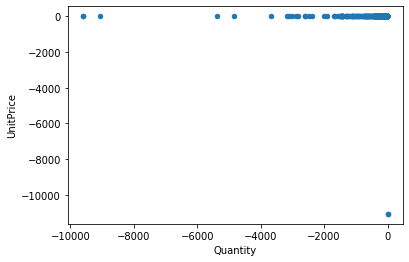

In [33]:
Valid_Transaction_Df[(Valid_Transaction_Df["UnitPrice"] < 0) | (Valid_Transaction_Df["Quantity"] < 0)][["Quantity", "UnitPrice"]].plot.scatter("Quantity", "UnitPrice")

I decided to drop these data since the UnitPrices are zeros or a huge negative number.

In [34]:
Valid_Transaction_Df = Valid_Transaction_Df[Valid_Transaction_Df["UnitPrice"] > 0]
Valid_Transaction_Df[["UnitPrice", "Quantity"]].describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00


After cleaning the `UnitPrice` and `Quantity`. I create the column `TotalPrice`.

In [35]:
Valid_Transaction_Df["TotalPrice"] = Valid_Transaction_Df["UnitPrice"] * Valid_Transaction_Df["Quantity"]

Change the CustomerID to string and replace Nan values with "Missing" in `Description`.

In [36]:
Valid_Transaction_Df["CustomerID"] = Valid_Transaction_Df["CustomerID"].apply(lambda x: "Missing" if pd.isnull(x) else str(int(x)))
Valid_Transaction_Df["Description_FillNA"] = Valid_Transaction_Df["Description"].fillna("Missing")

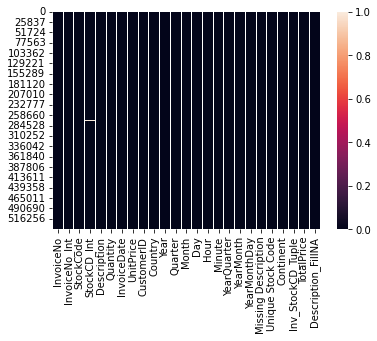

In [37]:
sns.heatmap(Valid_Transaction_Df.isna())
# No StockCode for Postage Products 

The white part which is the missing data in `StockCD_Int` is that there is no digit part of `StockCode` for postage products.

In [39]:
Valid_Transaction_Df.shape

(530104, 25)

In [ ]:
# Output Data after cleansing.
# Valid_Transaction_Df.to_csv("/content/Valid_Transaction_Data_cleaned.csv", index = False)

In [22]:
Valid_Transaction_Df.head(4)

,InvoiceNo,InvoiceNo_Int,StockCode,StockCD_Int,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Day,Hour,Minute,YearQuarter,YearMonth,YearMonthDay,Missing Description,Unique Stock Code,Continent,Inv_StockCD_Tuple,TotalPrice,Description_FillNA
0,536365,536365,85123A,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,85123,Europe,"(536365, 85123)",15.30,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,536365,71053,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,71053,Europe,"(536365, 71053)",20.34,WHITE METAL LANTERN
2,536365,536365,84406B,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,84406,Europe,"(536365, 84406)",22.00,CREAM CUPID HEARTS COAT HANGER
3,536365,536365,84029G,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,84029,Europe,"(536365, 84029)",20.34,KNITTED UNION FLAG HOT WATER BOTTLE


# **Feature Generation**

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from dateutil import relativedelta
import re
from functools import reduce
# Valid_Transaction_Df = pd.read_csv("/content/Valid_Transaction_Data.csv")
Valid_Transaction_Df["InvoiceDate"] = pd.to_datetime(Valid_Transaction_Df["InvoiceDate"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [40]:
Valid_Transaction_Df.shape # (530104, 25)

(530104, 25)

In [41]:
# Data For Question 2
# Since the objective is to analyze the customers, I remove the data with missing customer ID.
Q2_Data = Valid_Transaction_Df[Valid_Transaction_Df["CustomerID"] != "Missing"].copy()

In [42]:
print(Q2_Data.shape) # (397884, 25)
Q2_Data.head()

(397884, 25)


,InvoiceNo,InvoiceNo_Int,StockCode,StockCD_Int,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Quarter,Month,Day,Hour,Minute,YearQuarter,YearMonth,YearMonthDay,Missing Description,Unique Stock Code,Continent,Inv_StockCD_Tuple,TotalPrice,Description_FillNA
0,536365,536365,85123A,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,85123,Europe,"(536365, 85123)",15.30,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,536365,71053,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,71053,Europe,"(536365, 71053)",20.34,WHITE METAL LANTERN
2,536365,536365,84406B,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,84406,Europe,"(536365, 84406)",22.00,CREAM CUPID HEARTS COAT HANGER
3,536365,536365,84029G,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,84029,Europe,"(536365, 84029)",20.34,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,536365,84029E,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,4,12,1,8,26,2010-4,2010-12,2010-12-01,Description Not Missing,84029,Europe,"(536365, 84029)",20.34,RED WOOLLY HOTTIE WHITE HEART.


Start to generate features for each customer to analyze the similarity for the sample.

In [43]:
print("Total Customers Count : ", Q2_Data["CustomerID"].unique().size)

Total Customers Count :  4338


---



## Generate **RECENCY** relevant features.
### `Cust_Recency_Data`
- Mean days between two transaction date.
- The last transaction date of each customer to the last day of the data.

Mean days between two transaction date.

In [44]:
# How many days between two transactions (get mean for each customer).
Cust_Date_df = Q2_Data.copy()
Cust_Date_df["YearMonthDay"] = pd.to_datetime(Cust_Date_df["YearMonthDay"], format = "%Y-%m-%d")
Cust_Date_df = Cust_Date_df.sort_values(by = ["CustomerID", "YearMonthDay"])[["CustomerID", "YearMonthDay"]]
# For those customers who only have one transaction data, I give them the maximum day range of the data.
Cust_Date_df["DaysDiffPrevTrans"] = Cust_Date_df.groupby("CustomerID")["YearMonthDay"].diff().fillna(Q2_Data["InvoiceDate"].max()-Q2_Data["InvoiceDate"].min()).dt.days
Cust_MeanOfDaysDiff2PrevTrans = Cust_Date_df.groupby("CustomerID")["DaysDiffPrevTrans"].mean().reset_index().rename(columns = {"DaysDiffPrevTrans" : "MeanOfDaysDiffToPrevTrans"})
Cust_MeanOfDaysDiff2PrevTrans.head()

,CustomerID,MeanOfDaysDiffToPrevTrans
0,12346,373.000000
1,12347,4.054945
2,12348,21.161290
3,12349,5.109589
4,12350,21.941176


The last transaction date of each customer to the last day of the data.

In [46]:
# The days between data record day to the last day the customers purchase.
Cust_Date_df["DaysDiffToRecordDate"] = (Q2_Data["InvoiceDate"].max() - Q2_Data["InvoiceDate"]).dt.days
Cust_DaysCntToDataRecordTime = Cust_Date_df.groupby("CustomerID")["DaysDiffToRecordDate"].min().reset_index()
Cust_DaysCntToDataRecordTime.head()

,CustomerID,DaysDiffToRecordDate
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


In [47]:
# FINAL OUTPUT sub DataFrame for RECENCY Features.
Cust_Recency_Data = pd.merge(Cust_MeanOfDaysDiff2PrevTrans, Cust_DaysCntToDataRecordTime, how = "outer", on = "CustomerID")
Cust_Recency_Data.head()

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate
0,12346,373.000000,325
1,12347,4.054945,1
2,12348,21.161290,74
3,12349,5.109589,18
4,12350,21.941176,309


## Generate **Frequency** Feature.
### `Cust_Freq_Df`
- Total Invoice(transaction) Count	
- Year Frequency (How many years does the customer show up?)
- Quarter Frequency	(How many quarters does the customer show up?)
- Month Frequency (How many months does the customer show up?)
- Day Frequency (How many days does the customer show up?)

Total Invoice(transaction) Count

In [62]:
# Calculate Overall transaction frequency for each customer
# Total Invoice Count :
Total_Inv_Cnt_Df = Q2_Data.groupby("CustomerID")["InvoiceNo"].nunique().reset_index().rename(columns = {"InvoiceNo" : "Total_Invoice_Cnt"})
print(Total_Inv_Cnt_Df.shape)
Total_Inv_Cnt_Df.head()

(4338, 2)


,CustomerID,Total_Invoice_Cnt
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


Year, Quarter, Month, Day Frequency.

In [63]:
# Calculate Year Frequency :
Annually_Freq = Q2_Data.groupby(['CustomerID'])["Year"].nunique().reset_index().rename(columns = {"Year" : "YearFreq"})
# Calculate Quarter Frequency :
Quarterly_Freq = Q2_Data.groupby(['CustomerID'])["YearQuarter"].nunique().reset_index().rename(columns = {"YearQuarter" : "YearQuarterFreq"})
# Calculate Month Frequency :
Monthly_Freq = Q2_Data.groupby(['CustomerID'])["YearMonth"].nunique().reset_index().rename(columns = {"YearMonth" : "YearMonthFreq"})
# Calculate Day Frequency :
Daily_Freq = Q2_Data.groupby(['CustomerID'])["YearMonthDay"].nunique().reset_index().rename(columns = {"YearMonthDay" : "YearMonthDayFreq"})
# Combine
Cust_Freq_Df = reduce(lambda LD, RD : pd.merge(LD, RD, how = "outer", on = "CustomerID"),\
            [Total_Inv_Cnt_Df, Annually_Freq, Quarterly_Freq, Monthly_Freq, Daily_Freq])
print(Cust_Freq_Df.shape)
Cust_Freq_Df.head(2)

(4338, 6)


,CustomerID,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq
0,12346,1,1,1,1,1
1,12347,7,2,5,7,7


## Generate **Monetary** Features.
### `Monetary_Feature_Df`
- Total Expense.
- Mean Spending in each transactions.


Total Expense.

In [48]:
Total_Expense_Df = Q2_Data.groupby("CustomerID")["TotalPrice"].sum().reset_index().rename(columns = {"TotalPrice" : "TotalExpense"})
Total_Expense_Df.head(3)

,CustomerID,TotalExpense
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24


Mean Expense in each transaction (Total Expense / how many invoice)

In [49]:
MeanExpenseEachTransaction_Df = (Q2_Data.groupby("CustomerID")["TotalPrice"].sum() / Q2_Data.groupby("CustomerID")["InvoiceNo"].nunique()).reset_index().rename(columns = {0:"MeanExpenseEachTransaction"})

In [50]:
Monetary_Feature_Df = pd.merge(Total_Expense_Df, MeanExpenseEachTransaction_Df, how = "outer", on = "CustomerID")

## Generate **Location** Features.
### `Location_Feature_Df`
- Continent


Clean up the customers who have two different continent data.

In [51]:
temp = Q2_Data[["CustomerID", "Continent"]].drop_duplicates(["CustomerID", "Continent"])

In [52]:
np.where(temp.groupby("CustomerID")["Continent"].nunique() > 1)  

(array([60, 69]),)

In [53]:
temp.groupby("CustomerID")["Continent"].nunique()[[60, 69]]

CustomerID
12422    2
12431    2
Name: Continent, dtype: int64

In [54]:
temp[temp["CustomerID"].isin(["12422", "12431"])]

,CustomerID,Continent
197,12431,Oceania
63100,12422,Oceania
92481,12431,Europe
239276,12422,Europe


I decide to use the continent with higher transaction times.

In [55]:
# greater transaction count decide the location of the customer. 
Q2_Data[Q2_Data["CustomerID"].isin(["12422", "12431"])].groupby(["CustomerID", "Continent"])["InvoiceNo"].nunique()

CustomerID  Continent
12422       Europe        1
            Oceania       2
12431       Europe        2
            Oceania      13
Name: InvoiceNo, dtype: int64

In [56]:
temp.loc[temp["CustomerID"].isin(["12422", "12431"]), "Continent"] = "Oceania"
Cust_Location_Df = temp.drop_duplicates(["CustomerID", "Continent"])
Cust_Location_Df

,CustomerID,Continent
0,17850,Europe
9,13047,Europe
26,12583,Europe
46,13748,Europe
65,15100,Europe
...,...,...
536969,13436,Europe
537255,15520,Europe
538064,13298,Europe
538812,14569,Europe


## Create Customer Feature Whole Dataset.
### `Customer_Feature_Data`

In [64]:
Customer_Feature_Data = reduce(lambda LD, RD : pd.merge(LD, RD, how = "outer", on = "CustomerID"),[Cust_Recency_Data, Cust_Freq_Df, Monetary_Feature_Df, Cust_Location_Df])

In [66]:
Customer_Feature_Data.head()

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent
0,12346,373.000000,325,1,1,1,1,1,77183.60,77183.600000,Europe
1,12347,4.054945,1,7,2,5,7,7,4310.00,615.714286,Europe
2,12348,21.161290,74,4,2,4,4,4,1797.24,449.310000,Europe
3,12349,5.109589,18,1,1,1,1,1,1757.55,1757.550000,Europe
4,12350,21.941176,309,1,1,1,1,1,334.40,334.400000,Europe


In [113]:
# Customer_Feature_Data.to_csv("/content/Customer_Feature_Data.csv", index = False)

# **Clustering Analysis**

### Tidy up the data.

Preprocessing using scale at first.

In [67]:
from sklearn.preprocessing import scale, minmax_scale

In [68]:
Customer_Feature_Data.set_index("CustomerID", inplace = True)
print(Customer_Feature_Data.shape) # (4338, 10)
Customer_Feature_Data.head()

(4338, 10)


,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent
CustomerID,,,,,,,,,,
12346,373.000000,325,1,1,1,1,1,77183.60,77183.600000,Europe
12347,4.054945,1,7,2,5,7,7,4310.00,615.714286,Europe
12348,21.161290,74,4,2,4,4,4,1797.24,449.310000,Europe
12349,5.109589,18,1,1,1,1,1,1757.55,1757.550000,Europe
12350,21.941176,309,1,1,1,1,1,334.40,334.400000,Europe


Since KMeans is sensitive to the distance between each data, I scale the data to further reduce the huge impact of outliers or a high value of data.

In [69]:
Customer_Feature_Data_Scale = Customer_Feature_Data.apply(lambda x : (x - x.mean()) / x.std() if x.dtypes != "O" else x)
DataForCluster = pd.get_dummies(Customer_Feature_Data_Scale, columns = ["Continent"], prefix = "Continent").drop("Continent_Unspecified", axis = 1)

In [117]:
# DataForCluster.to_csv("/content/Cluster_Data_Scaled_Dummied.csv", index = True)

### Adopt Clustering Algorithm KMeans.

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [71]:
DataForCluster.head(3)

,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
CustomerID,,,,,,,,,,,,,,,
12346,6.364713,2.334305,-0.425048,-0.463029,-0.897152,-0.764587,-0.481463,8.357705,42.729091,0,0,1,0,0,0
12347,-0.429990,-0.905236,0.354376,2.159192,2.194681,1.518646,0.527110,0.250937,0.109404,0,0,1,0,0,0
12348,-0.114949,-0.175339,-0.035336,2.159192,1.421723,0.377030,0.022823,-0.028593,0.016779,0,0,1,0,0,0


**Silhouette Coeffecient**

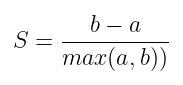

b = 每一個點與其他**和該點不同簇樣本**的平均距離

a = 每一個點與其他**和該點同簇樣本**的平均距離

Silhouette_score 回傳全部樣本的平均S。

In [74]:
def Kmeans_Clustering(Data) :
  silhouette_coef_list = []
  SSE_list = []
  n_cluster = np.arange(2, 15)
  for i in n_cluster :
    kmeans = KMeans(n_clusters= i, n_init = 10, random_state = 1115)
    kmeans.fit(Data)

    silhouette_coef = silhouette_score(Data, kmeans.labels_)
    silhouette_coef_list.append(silhouette_coef)
    SSE_list.append(kmeans.inertia_)

  print(*[f"{x:.4f}" for x in silhouette_coef_list])

  fig,ax = plt.subplots()
  ax.plot(n_cluster, silhouette_coef_list, c = "r", linewidth = 3, marker = "o")
  ax.set_xlabel("Number of Cluster")
  ax.set_ylabel("Silhouette Coeffecient", c = "r")

  ax2=ax.twinx()
  ax2.plot(n_cluster, SSE_list, c = "b",linewidth = 3, marker = "o")
  ax2.set_ylabel("Elbow Method", c = "b")
  plt.show()

### Use **Min Max Scale** because of the dummy variables in the data, I think make all columns transform into 0 and 1 is better for the cluster to measure the distance.

In [129]:
Customer_Feature_Data_MinMax = Customer_Feature_Data.apply(lambda x : (x - x.min()) / (x.max()-x.min()) if x.dtypes != "O" else x)
DataForCluster_MinMax = pd.get_dummies(Customer_Feature_Data_MinMax, columns = ["Continent"], prefix = "Continent").drop("Continent_Unspecified", axis = 1)

In [130]:
DataForCluster_MinMax.head()

,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
CustomerID,,,,,,,,,,,,,,,
12346,1.000000,0.871314,0.000000,0.0,0.00,0.00,0.000000,0.275443,0.916272,0,0,1,0,0,0
12347,0.010627,0.002681,0.028846,1.0,1.00,0.50,0.045802,0.015368,0.007269,0,0,1,0,0,0
12348,0.056500,0.198391,0.014423,1.0,0.75,0.25,0.022901,0.006401,0.005293,0,0,1,0,0,0
12349,0.013455,0.048257,0.000000,0.0,0.00,0.00,0.000000,0.006259,0.020824,0,0,1,0,0,0
12350,0.058591,0.828418,0.000000,0.0,0.00,0.00,0.000000,0.001180,0.003929,0,0,1,0,0,0


In [ ]:
DataForCluster_MinMax.agg(["min", "max"]).T

0.5787 0.3931 0.4638 0.4684 0.4857 0.4962 0.4568 0.4520 0.4319 0.4534 0.4499 0.4519 0.4622


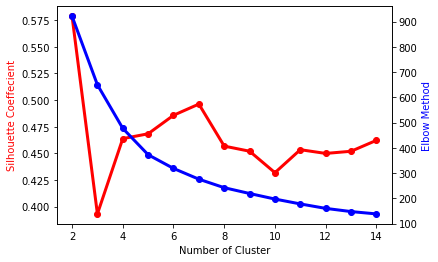

In [132]:
Kmeans_Clustering(DataForCluster_MinMax)

In [134]:
# Cluster = 7
final_kmeans_MinMax = KMeans(7, n_init=30).fit(DataForCluster_MinMax)

In [135]:
Cluster_Analysis_Origin_MinMax = Customer_Feature_Data.copy().assign(Cluster = final_kmeans_MinMax.labels_)
Cluster_Analysis_Origin_MinMax.head(3)

,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent,Cluster
CustomerID,,,,,,,,,,,
12346,373.000000,325,1,1,1,1,1,77183.60,77183.600000,Europe,4
12347,4.054945,1,7,2,5,7,7,4310.00,615.714286,Europe,6
12348,21.161290,74,4,2,4,4,4,1797.24,449.310000,Europe,2


In [145]:
Cluster_Analysis_Origin_MinMax = Cluster_Analysis_Origin_MinMax.reset_index()
Cluster_Analysis_Origin_MinMax.to_csv("/content/ClusterResult_Cust_Feature_Data.csv")
# Cluster_Analysis_Origin_MinMax.to_csv("/content/Customers_Feature_Data_7_Cluster_label_MinMax.csv", index = False)

### Interprete Clustering Result (Min Max Scale Ver.)

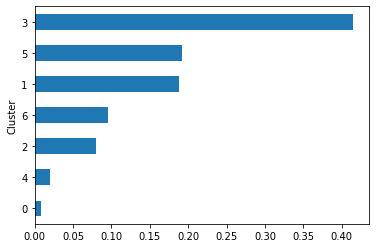

In [147]:
(Cluster_Analysis_Origin_MinMax.reset_index().groupby("Cluster")["CustomerID"].count()/Cluster_Analysis_Origin_MinMax.reset_index()["CustomerID"].count()).sort_values().plot.barh()

Since the outliers are too anoying when giving a visualization.

I decide to plot the data distribution between `n` times of std greater than median.

In [176]:
Cluster_Analysis_Origin_MinMax.head()

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarterFreq,YearMonthFreq,YearMonthDayFreq,TotalExpense,MeanExpenseEachTransaction,Continent,Cluster
0,12346,373.000000,325,1,1,1,1,1,77183.60,77183.600000,Europe,4
1,12347,4.054945,1,7,2,5,7,7,4310.00,615.714286,Europe,6
2,12348,21.161290,74,4,2,4,4,4,1797.24,449.310000,Europe,2
3,12349,5.109589,18,1,1,1,1,1,1757.55,1757.550000,Europe,3
4,12350,21.941176,309,1,1,1,1,1,334.40,334.400000,Europe,5


In [167]:
def Extract_Middle_Part_of_Data(in_x, n) :
  x = in_x.copy()

  M = x.median()
  S = x.std()
  UP = M + n * S
  LOW = M - n * S

  return x[(x > LOW) & (x < UP)]

In [ ]:
for i in Cluster_Analysis_Origin_MinMax.set_index("CustomerID").columns[:-2] :
  print(f"Variable : [{i}]")
  temp = Cluster_Analysis_Origin_MinMax[[i, "Cluster"]].apply(lambda x : Extract_Middle_Part_of_Data(x, 1.5) if x.dtypes != "O" else x).dropna(how = "any")
  sns.boxplot(x = "Cluster", y = i, data = temp)  
  plt.show()

In [192]:
def Boxplot_Interpretation(Data, Variable, n, i):
  temp = Data[[Variable, "Cluster"]].apply(lambda x : Extract_Middle_Part_of_Data(x, 1.5) if x.dtypes != "O" else x)
  sns.boxplot(x = "Cluster", y = Variable, data = temp, ax = ax[i])

##### Plot Location Clustering Result

In [209]:
from plotnine import *

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


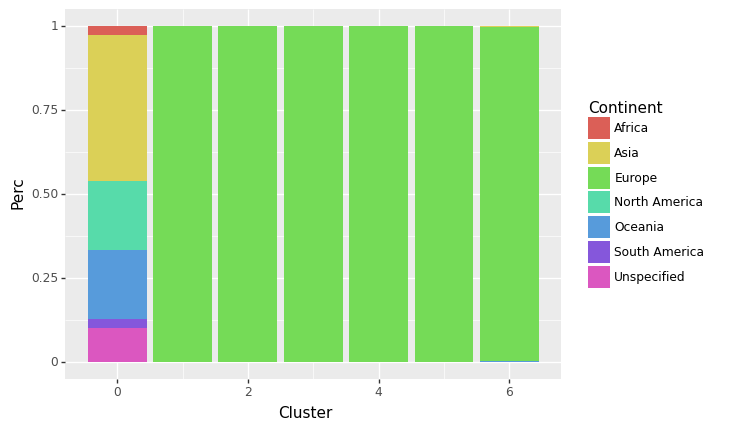

<ggplot: (8736038502257)>

In [211]:
temp = Cluster_Analysis_Origin_MinMax.groupby(["Cluster", "Continent"])["CustomerID"].count().reset_index().merge(\
  Cluster_Analysis_Origin_MinMax.groupby("Cluster")["CustomerID"].count().reset_index().rename(columns = {"CustomerID" : "TotalSample"}), how = "left", on = "Cluster")
temp = temp.assign(Perc = temp.CustomerID / temp.TotalSample)
(
ggplot(temp) +
 geom_bar(aes(x = "Cluster",y = "Perc", fill = "Continent"), position = "stack", stat = "identity")
)

##### Plot the core **RECENCY**, **FREQUENCY**, **MONETARY** Variables

I choose four variables that I think is the most important feature in the data.

- DaysDiffToRecordDate
- Total_Invoice_Cnt
- TotalExpense
- MeanExpenseEachTransaction

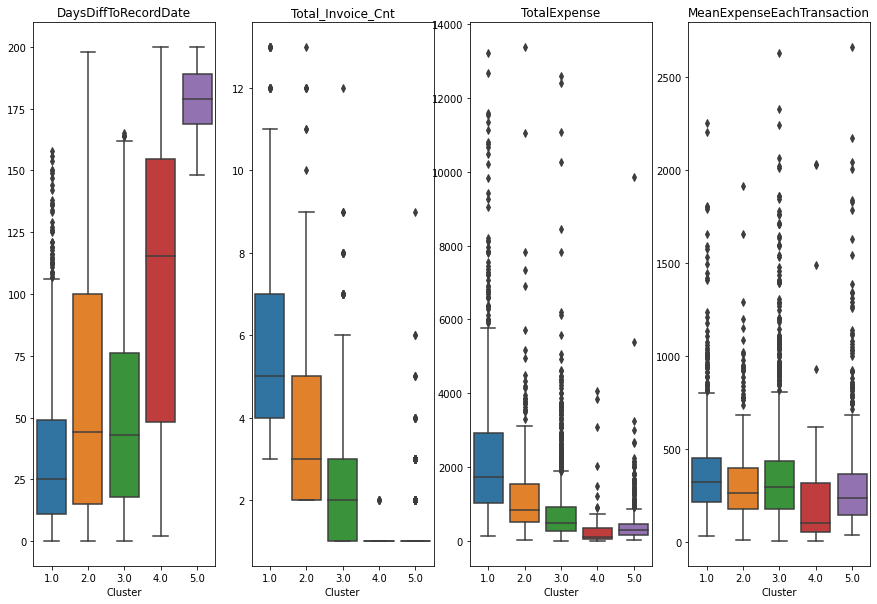

In [200]:
fig, ax = plt.subplots(1, 4, figsize=(15,10))
Boxplot_Interpretation(Cluster_Analysis_Origin_MinMax, "DaysDiffToRecordDate", 2, 0)
ax[0].set_ylabel("")
ax[0].set_title("DaysDiffToRecordDate")
Boxplot_Interpretation(Cluster_Analysis_Origin_MinMax, "Total_Invoice_Cnt", 2, 1)
ax[1].set_ylabel("")
ax[1].set_title("Total_Invoice_Cnt")
Boxplot_Interpretation(Cluster_Analysis_Origin_MinMax, "TotalExpense", 1.5, 2)
ax[2].set_ylabel("")
ax[2].set_title("TotalExpense")
Boxplot_Interpretation(Cluster_Analysis_Origin_MinMax, "MeanExpenseEachTransaction", 1.5, 3)
ax[3].set_ylabel("")
ax[3].set_title("MeanExpenseEachTransaction")
plt.show()

# **Clustering Analysis Result Detail**
**Recency :** 

We can see that for the customers' frequency feature. Customers in Cluster `1` has purchase more closely to the data record day than other customers. Which We can consider those are customers with greater loyalty.

**Frequency :**

Customers in Cluster `1` also have a higher frequency on purchasing in the shop.
And then comes the Cluster `2` followed by Cluster `3`.

**Monetary :**

We can See that the Customers in Cluster`1`, `3` and `5` has a close average expense on each transaction. But Combining to the Frequency data, which also means that the Total Price in the whole data period, Customers in Cluster `1` has a greater contribution on the sales revenue of the store.

**Location :**

We can see that there is no obvious location difference on each cluster, and I also remove the continent variable and rerun the KMeans. The result comes out with no difference. We can know that Location data is not a big deal on the customers for the shop.

**Other Groups :**

We can see that since I only plot the data between median values plus or minus `n` times of standard deviation. Cluster `0`, `6` are those with outliers value or abnormal values. I decide to ignore those noise-like customers or data.

In [213]:
# Cluster_Analysis_Origin_MinMax.to_csv("/content/Customers_Feature_Data_7_Cluster_label_MinMax.csv", index = False)

# Below are the part I have done first. But the result becomes different after I reconnect the colab service.

### Interprete the reuslt after Kmeans.

In [ ]:
kmeans_final_scale = KMeans(n_clusters= 3, n_init = 10, random_state = 1115).fit(DataForCluster)

In [ ]:
Cluster_Analysis_Origin_Scale = Customer_Feature_Data.copy().assign(Cluster = kmeans_final_scale.labels_)
Cluster_Analysis_Origin_Scale.head(3)

In [ ]:
for i in Cluster_Analysis_Origin_Scale.columns[:-2] :
  print(f"Variable : [{i}]")
  sns.boxplot(x = "Cluster", y = i, data = Cluster_Analysis_Origin_Scale)
  plt.show()

Outliers have a big impact. Try to use a simple transformation to reduce the data range.

In [ ]:
def Clamp_transformation(inx, n) :
  x = inx.copy()
  M = x.median()
  S = x.std()
  UP = M + n * S
  LOW = M - n * S
  # print(M)
  # print(S)
  # print(UP)
  # print(LOW)
  x[x>UP] = UP
  x[x<LOW] = LOW
  return x

In [ ]:
Customer_Feature_Data_Clamp = Customer_Feature_Data.apply(lambda x : Clamp_transformation(x, 2) if ((x.dtypes == "int64") or (x.dtypes == "float64")) else x)

In [ ]:
# Check data distribution after the transformation
for i in np.arange(1, 10) :
  print(f"========={Customer_Feature_Data.columns[i]}=========")
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Original          Clamp')
  ax1.boxplot(Customer_Feature_Data.iloc[:, i])
  ax2.boxplot(Customer_Feature_Data_Clamp.iloc[:, i])
  plt.show()
# Seems Better.

### Retrain the Kmeans Clustering model after data transformation.

In [ ]:
Customer_Feature_Data_Clamp.head(3)

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarter,YearMonth,YearMonthDay,TotalExpense,MeanExpenseEachTransaction,Continent
0,12346,120.254102,250.028337,1.0,1.000000,1.000000,1.0,1.0,18652.945883,3886.975889,Europe
1,12347,4.054945,1.000000,7.0,1.762712,4.587462,7.0,7.0,4310.000000,615.714286,Europe
2,12348,21.161290,74.000000,4.0,1.762712,4.000000,4.0,4.0,1797.240000,449.310000,Europe


In [ ]:
Customer_Feature_Data_Clamp_Scale = Customer_Feature_Data_Clamp.apply(lambda x : (x - x.mean()) / x.std() if x.dtypes != "O" else x)
DataForCluster_Clamp = pd.get_dummies(Customer_Feature_Data_Clamp_Scale, columns = ["Continent"], prefix = "Continent").drop("Continent_Unspecified", axis = 1)

In [ ]:
DataForCluster_Clamp.head(3)

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarter,YearMonth,YearMonthDay,TotalExpense,MeanExpenseEachTransaction,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,12346,3.529626,1.933432,-0.712347,-0.463029,-0.920321,-0.878241,-0.742586,6.284218,8.914727,0,0,1,0,0,0
1,12347,-0.646154,-0.982295,0.822798,2.159192,2.005025,2.065889,1.071393,1.003067,0.606247,0,0,1,0,0,0
2,12348,-0.031414,-0.127581,0.055225,2.159192,1.525987,0.593824,0.164403,0.077856,0.183607,0,0,1,0,0,0


0.6238 0.5908 0.5707 0.5657 0.5554 0.5497 0.5427 0.5442 0.5455 0.5414 0.5394 0.5369 0.5350


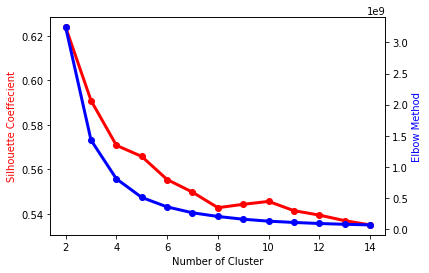

In [ ]:
Kmeans_Clustering(DataForCluster_Clamp)

4 Clusters seems to be a better choice since a higher Silhouette coef.

In [ ]:
kmeans_final_Clamp = KMeans(n_clusters= 4, n_init = 30, random_state = 1115).fit(DataForCluster_Clamped)

In [ ]:
Cluster_Analysis_Origin_Clamp = Customer_Feature_Data.copy().assign(Cluster = kmeans_final_Clamp.labels_)
Cluster_Analysis_Origin_Clamp.head(3)

,CustomerID,MeanOfDaysDiffToPrevTrans,DaysDiffToRecordDate,Total_Invoice_Cnt,YearFreq,YearQuarter,YearMonth,YearMonthDay,TotalExpense,MeanExpenseEachTransaction,Continent,Cluster
0,12346,373.000000,325,1,1,1,1,1,77183.60,77183.600000,Europe,2
1,12347,4.054945,1,7,2,5,7,7,4310.00,615.714286,Europe,3
2,12348,21.161290,74,4,2,4,4,4,1797.24,449.310000,Europe,1
